In [1]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
sns.set()
tf.compat.v1.random.set_random_seed(1234)

In [3]:
df = pd.read_csv('../dataset/GOOG-year.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-11-02,778.200012,781.650024,763.450012,768.700012,768.700012,1872400
1,2016-11-03,767.250000,769.950012,759.030029,762.130005,762.130005,1943200
2,2016-11-04,750.659973,770.359985,750.560974,762.020020,762.020020,2134800
3,2016-11-07,774.500000,785.190002,772.549988,782.520020,782.520020,1585100
4,2016-11-08,783.400024,795.632996,780.190002,790.510010,790.510010,1350800


In [4]:
minmax = MinMaxScaler().fit(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = minmax.transform(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = pd.DataFrame(df_log)
df_log.head()

,0
0,0.112708
1,0.090008
2,0.089628
3,0.160459
4,0.188066


## Split train and test

I will cut the dataset to train and test datasets,

1. Train dataset derived from starting timestamp until last 30 days
2. Test dataset derived from last 30 days until end of the dataset

So we will let the model do forecasting based on last 30 days, and we will going to repeat the experiment for 10 times. You can increase it locally if you want, and tuning parameters will help you by a lot.

In [5]:
test_size = 30
simulation_size = 10

df_train = df_log.iloc[:-test_size]
df_test = df_log.iloc[-test_size:]
df.shape, df_train.shape, df_test.shape

((252, 7), (222, 1), (30, 1))

In [6]:
def layer_norm(inputs, epsilon=1e-8):
    mean, variance = tf.nn.moments(inputs, [-1], keep_dims=True)
    normalized = (inputs - mean) / (tf.sqrt(variance + epsilon))

    params_shape = inputs.get_shape()[-1:]
    gamma = tf.get_variable('gamma', params_shape, tf.float32, tf.ones_initializer())
    beta = tf.get_variable('beta', params_shape, tf.float32, tf.zeros_initializer())
    
    outputs = gamma * normalized + beta
    return outputs

def multihead_attn(queries, keys, q_masks, k_masks, future_binding, num_units, num_heads):
    
    T_q = tf.shape(queries)[1]                                      
    T_k = tf.shape(keys)[1]                  

    Q = tf.layers.dense(queries, num_units, name='Q')                              
    K_V = tf.layers.dense(keys, 2*num_units, name='K_V')    
    K, V = tf.split(K_V, 2, -1)        

    Q_ = tf.concat(tf.split(Q, num_heads, axis=2), axis=0)                         
    K_ = tf.concat(tf.split(K, num_heads, axis=2), axis=0)                    
    V_ = tf.concat(tf.split(V, num_heads, axis=2), axis=0)                      

    align = tf.matmul(Q_, tf.transpose(K_, [0,2,1]))                      
    align = align / np.sqrt(K_.get_shape().as_list()[-1])                 

    paddings = tf.fill(tf.shape(align), float('-inf'))                   

    key_masks = k_masks                                                 
    key_masks = tf.tile(key_masks, [num_heads, 1])                       
    key_masks = tf.tile(tf.expand_dims(key_masks, 1), [1, T_q, 1])            
    align = tf.where(tf.equal(key_masks, 0), paddings, align)       

    if future_binding:
        lower_tri = tf.ones([T_q, T_k])                                          
        lower_tri = tf.linalg.LinearOperatorLowerTriangular(lower_tri).to_dense()  
        masks = tf.tile(tf.expand_dims(lower_tri,0), [tf.shape(align)[0], 1, 1]) 
        align = tf.where(tf.equal(masks, 0), paddings, align)                      
    
    align = tf.nn.softmax(align)                                            
    query_masks = tf.to_float(q_masks)                                             
    query_masks = tf.tile(query_masks, [num_heads, 1])                             
    query_masks = tf.tile(tf.expand_dims(query_masks, -1), [1, 1, T_k])            
    align *= query_masks
    
    outputs = tf.matmul(align, V_)                                                 
    outputs = tf.concat(tf.split(outputs, num_heads, axis=0), axis=2)             
    outputs += queries                                                             
    outputs = layer_norm(outputs)                                                 
    return outputs


def pointwise_feedforward(inputs, hidden_units, activation=None):
    outputs = tf.layers.dense(inputs, 4*hidden_units, activation=activation)
    outputs = tf.layers.dense(outputs, hidden_units, activation=None)
    outputs += inputs
    outputs = layer_norm(outputs)
    return outputs


def learned_position_encoding(inputs, mask, embed_dim):
    T = tf.shape(inputs)[1]
    outputs = tf.range(tf.shape(inputs)[1])                # (T_q)
    outputs = tf.expand_dims(outputs, 0)                   # (1, T_q)
    outputs = tf.tile(outputs, [tf.shape(inputs)[0], 1])   # (N, T_q)
    outputs = embed_seq(outputs, T, embed_dim, zero_pad=False, scale=False)
    return tf.expand_dims(tf.to_float(mask), -1) * outputs


def sinusoidal_position_encoding(inputs, mask, repr_dim):
    T = tf.shape(inputs)[1]
    pos = tf.reshape(tf.range(0.0, tf.to_float(T), dtype=tf.float32), [-1, 1])
    i = np.arange(0, repr_dim, 2, np.float32)
    denom = np.reshape(np.power(10000.0, i / repr_dim), [1, -1])
    enc = tf.expand_dims(tf.concat([tf.sin(pos / denom), tf.cos(pos / denom)], 1), 0)
    return tf.tile(enc, [tf.shape(inputs)[0], 1, 1]) * tf.expand_dims(tf.to_float(mask), -1)

def label_smoothing(inputs, epsilon=0.1):
    C = inputs.get_shape().as_list()[-1]
    return ((1 - epsilon) * inputs) + (epsilon / C)

class Attention:
    def __init__(self, size_layer, embedded_size, learning_rate, size, output_size,
                 num_blocks = 2,
                 num_heads = 8,
                 min_freq = 50):
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, output_size))
        
        encoder_embedded = tf.layers.dense(self.X, embedded_size)
        encoder_embedded = tf.nn.dropout(encoder_embedded, keep_prob = 0.8)
        x_mean = tf.reduce_mean(self.X, axis = 2)
        en_masks = tf.sign(x_mean)
        encoder_embedded += sinusoidal_position_encoding(self.X, en_masks, embedded_size)
        
        for i in range(num_blocks):
            with tf.variable_scope('encoder_self_attn_%d'%i,reuse=tf.AUTO_REUSE):
                encoder_embedded = multihead_attn(queries = encoder_embedded,
                                             keys = encoder_embedded,
                                             q_masks = en_masks,
                                             k_masks = en_masks,
                                             future_binding = False,
                                             num_units = size_layer,
                                             num_heads = num_heads)

            with tf.variable_scope('encoder_feedforward_%d'%i,reuse=tf.AUTO_REUSE):
                encoder_embedded = pointwise_feedforward(encoder_embedded,
                                                    embedded_size,
                                                    activation = tf.nn.relu)
                
        self.logits = tf.layers.dense(encoder_embedded[-1], output_size)
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )
        
def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [7]:
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 300
dropout_rate = 0.8
future_day = test_size
learning_rate = 0.001

In [8]:
def forecast():
    tf.reset_default_graph()
    modelnn = Attention(size_layer, size_layer, learning_rate, df_log.shape[1], df_log.shape[1])
    sess = tf.InteractiveSession()
    sess.run(tf.global_variables_initializer())
    date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

    pbar = tqdm(range(epoch), desc = 'train loop')
    for i in pbar:
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, _, loss = sess.run(
                [modelnn.logits, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y
                },
            ) 
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
        pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))
    
    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits = sess.run(
            modelnn.logits,
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                )
            },
        )
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits = sess.run(
            modelnn.logits,
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0)
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(days = 1))
    
    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits = sess.run(
            modelnn.logits,
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0)
            },
        )
        output_predict[-future_day + i] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(days = 1))
    
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)
    
    return deep_future[-test_size:]

In [9]:
results = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    results.append(forecast())

W0817 12:08:12.096583 140064997701440 deprecation.py:323] From <ipython-input-6-24d2a24c36ef>:91: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0817 12:08:12.104836 140064997701440 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


simulation 1


W0817 12:08:12.294501 140064997701440 deprecation.py:506] From <ipython-input-6-24d2a24c36ef>:92: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0817 12:08:12.305350 140064997701440 deprecation.py:323] From <ipython-input-6-24d2a24c36ef>:73: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
W0817 12:08:12.446460 140064997701440 deprecation.py:323] From <ipython-input-6-24d2a24c36ef>:33: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
train loop: 100%|██████████| 300/300 [01:41<00:00,  2.97it/s, acc=96.7, cost=0.00409] 


simulation 2


train loop: 100%|██████████| 300/300 [01:40<00:00,  2.99it/s, acc=97.3, cost=0.00184] 


simulation 3


train loop: 100%|██████████| 300/300 [01:40<00:00,  2.98it/s, acc=96.7, cost=0.00351] 


simulation 4


train loop: 100%|██████████| 300/300 [01:40<00:00,  2.98it/s, acc=97.9, cost=0.00112] 


simulation 5


train loop: 100%|██████████| 300/300 [01:41<00:00,  2.97it/s, acc=98, cost=0.00113]   


simulation 6


train loop: 100%|██████████| 300/300 [01:40<00:00,  2.98it/s, acc=97.5, cost=0.00165] 


simulation 7


train loop: 100%|██████████| 300/300 [01:41<00:00,  2.96it/s, acc=95.8, cost=0.00513]


simulation 9


train loop: 100%|██████████| 300/300 [01:41<00:00,  2.98it/s, acc=98, cost=0.000974]  


simulation 10


train loop: 100%|██████████| 300/300 [01:40<00:00,  2.99it/s, acc=96.8, cost=0.00322] 


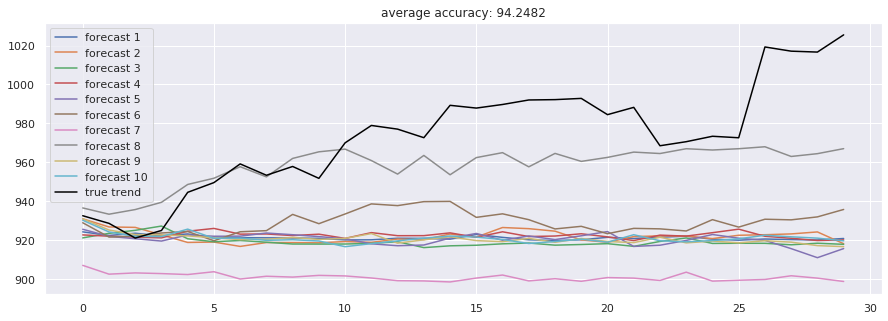

In [10]:
accuracies = [calculate_accuracy(df['Close'].iloc[-test_size:].values, r) for r in results]

plt.figure(figsize = (15, 5))
for no, r in enumerate(results):
    plt.plot(r, label = 'forecast %d'%(no + 1))
plt.plot(df['Close'].iloc[-test_size:].values, label = 'true trend', c = 'black')
plt.legend()
plt.title('average accuracy: %.4f'%(np.mean(accuracies)))
plt.show()

Simulation 1


Training: 100%|██████████| 300/300 [07:10<00:00,  1.43s/it]


Simulation 2


Training: 100%|██████████| 300/300 [06:03<00:00,  1.21s/it]


Simulation 3


Training: 100%|██████████| 300/300 [05:56<00:00,  1.19s/it]


Simulation 4


Training: 100%|██████████| 300/300 [54:19<00:00, 10.86s/it]    


Simulation 5


Training: 100%|██████████| 300/300 [07:14<00:00,  1.45s/it]


Simulation 6


Training: 100%|██████████| 300/300 [07:42<00:00,  1.54s/it]


Simulation 7


Training: 100%|██████████| 300/300 [11:06<00:00,  2.22s/it]


Simulation 8


Training: 100%|██████████| 300/300 [08:52<00:00,  1.78s/it]


Simulation 9


Training: 100%|██████████| 300/300 [07:20<00:00,  1.47s/it]


Simulation 10


Training: 100%|██████████| 300/300 [06:27<00:00,  1.29s/it]


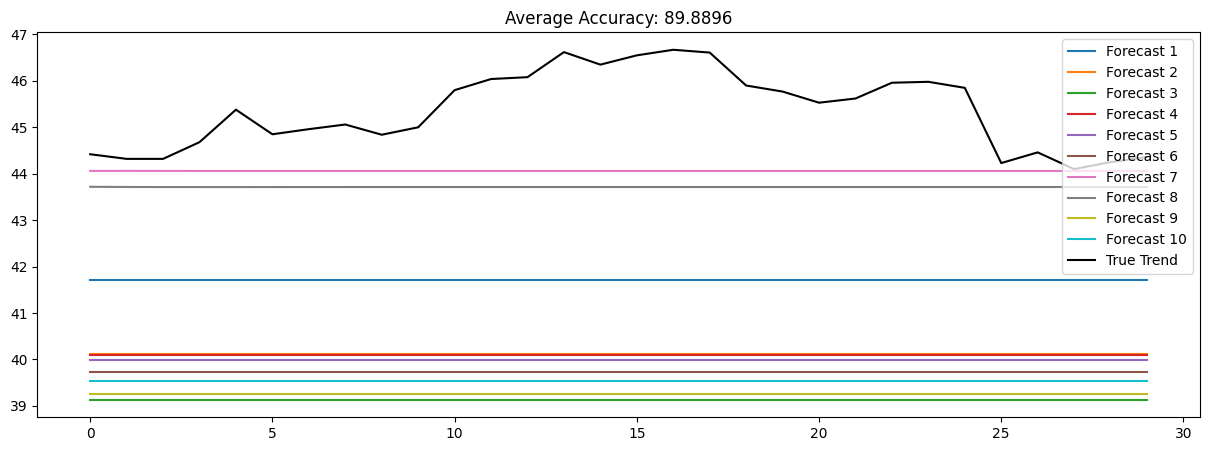

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from datetime import timedelta
from tqdm import tqdm

# --- Load Dataset ---
df = pd.read_csv('/home/priya/Desktop/fyp/Agents/data_store/D05.SI.csv')
scaler = MinMaxScaler()
df_log = scaler.fit_transform(df[['Close']].astype('float32'))
df_log = pd.DataFrame(df_log)

# --- Train/Test Split ---
test_size = 30
simulation_size = 10
df_train = df_log.iloc[:-test_size]
df_test = df_log.iloc[-test_size:]

# --- Utility Functions ---
def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight=0.3):
    buffer = []
    last = signal[0]
    for val in signal:
        smoothed = last * weight + (1 - weight) * val
        buffer.append(smoothed)
        last = smoothed
    return buffer

# --- Model Components ---
class LayerNormalization(tf.keras.layers.Layer):
    def __init__(self, epsilon=1e-6):
        super().__init__()
        self.epsilon = epsilon

    def build(self, input_shape):
        self.gamma = self.add_weight(name="gamma", shape=input_shape[-1:], initializer="ones")
        self.beta = self.add_weight(name="beta", shape=input_shape[-1:], initializer="zeros")

    def call(self, x):
        mean = tf.reduce_mean(x, axis=-1, keepdims=True)
        variance = tf.reduce_mean(tf.square(x - mean), axis=-1, keepdims=True)
        norm_x = (x - mean) / tf.sqrt(variance + self.epsilon)
        return self.gamma * norm_x + self.beta

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, num_units, num_heads, future_binding=False):
        super().__init__()
        self.num_units = num_units
        self.num_heads = num_heads
        self.future_binding = future_binding
        self.q_dense = tf.keras.layers.Dense(num_units)
        self.kv_dense = tf.keras.layers.Dense(num_units * 2)
        self.norm = LayerNormalization()

    def call(self, queries, keys, q_mask, k_mask):
        Q = self.q_dense(queries)
        K, V = tf.split(self.kv_dense(keys), 2, axis=-1)

        Q_ = tf.concat(tf.split(Q, self.num_heads, axis=-1), axis=0)
        K_ = tf.concat(tf.split(K, self.num_heads, axis=-1), axis=0)
        V_ = tf.concat(tf.split(V, self.num_heads, axis=-1), axis=0)

        scores = tf.matmul(Q_, K_, transpose_b=True) / tf.math.sqrt(tf.cast(self.num_units // self.num_heads, tf.float32))
        paddings = tf.ones_like(scores) * -1e9

        key_mask = tf.tile(k_mask, [self.num_heads, 1])
        key_mask = tf.tile(tf.expand_dims(key_mask, 1), [1, tf.shape(scores)[1], 1])
        scores = tf.where(tf.equal(key_mask, 0), paddings, scores)

        if self.future_binding:
            size = tf.shape(scores)[1]
            mask = tf.linalg.band_part(tf.ones((size, size)), -1, 0)
            scores = tf.where(tf.equal(mask, 0), paddings, scores)

        align = tf.nn.softmax(scores)
        query_mask = tf.tile(tf.expand_dims(q_mask, -1), [self.num_heads, 1, tf.shape(scores)[-1]])
        align *= tf.cast(query_mask, tf.float32)

        context = tf.matmul(align, V_)
        context = tf.concat(tf.split(context, self.num_heads, axis=0), axis=2)
        return self.norm(context + queries)

class FeedForward(tf.keras.layers.Layer):
    def __init__(self, hidden_units):
        super().__init__()
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(4 * hidden_units, activation='relu'),
            tf.keras.layers.Dense(hidden_units)
        ])
        self.norm = LayerNormalization()

    def call(self, x):
        return self.norm(self.ffn(x) + x)

class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, embed_dim):
        super().__init__()
        self.embed_dim = embed_dim

    def call(self, x):
        batch, seq_len = tf.shape(x)[0], tf.shape(x)[1]
        pos = tf.range(seq_len, dtype=tf.float32)[:, tf.newaxis]
        i = tf.range(self.embed_dim // 2, dtype=tf.float32)[tf.newaxis, :]
        angle_rates = 1 / tf.pow(10000.0, (2 * i) / tf.cast(self.embed_dim, tf.float32))
        angles = pos * angle_rates
        pos_encoding = tf.concat([tf.sin(angles), tf.cos(angles)], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return x + pos_encoding

# --- Main Model ---
class AttentionModel(tf.keras.Model):
    def __init__(self, size_layer, embed_size, output_size, num_heads=8, num_blocks=2):
        super().__init__()
        self.embed = tf.keras.layers.Dense(embed_size)
        self.dropout = tf.keras.layers.Dropout(0.2)
        self.pos_enc = PositionalEncoding(embed_size)

        self.attn_layers = []
        for _ in range(num_blocks):
            self.attn_layers.append([
                MultiHeadAttention(size_layer, num_heads),
                FeedForward(embed_size)
            ])
        self.out = tf.keras.layers.Dense(output_size)

    def call(self, x, training=False):
        x_embed = self.embed(x)
        x_embed = self.dropout(x_embed, training=training)
        x_embed = self.pos_enc(x_embed)

        mask = tf.cast(tf.reduce_sum(tf.abs(x), axis=2) > 0, tf.float32)

        for mha, ffn in self.attn_layers:
            x_embed = mha(x_embed, x_embed, mask, mask)
            x_embed = ffn(x_embed)

        return self.out(x_embed[:, -1])

# --- Forecasting Function ---
def forecast():
    model = AttentionModel(size_layer=128, embed_size=128, output_size=1)
    optimizer = tf.keras.optimizers.Adam(0.001)
    mse = tf.keras.losses.MeanSquaredError()

    @tf.function
    def train_step(x, y):
        with tf.GradientTape() as tape:
            pred = model(x, training=True)
            loss = mse(y, pred)
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        return loss

    for epoch in tqdm(range(300), desc='Training'):
        for i in range(0, len(df_train) - 6):
            x_batch = np.expand_dims(df_train.iloc[i:i+5].values, axis=0)
            y_batch = df_train.iloc[i+5:i+6].values
            train_step(tf.convert_to_tensor(x_batch, dtype=tf.float32),
                       tf.convert_to_tensor(y_batch, dtype=tf.float32))

    full_data = df_train.copy()
    for _ in range(test_size):
        x_input = np.expand_dims(full_data[-5:].values, axis=0)
        pred = model(tf.convert_to_tensor(x_input, dtype=tf.float32), training=False)
        full_data = pd.concat([full_data, pd.DataFrame(pred.numpy())])

    output = scaler.inverse_transform(full_data[-test_size:])
    return anchor(output[:, 0])

# --- Run Forecasting ---
results = []
for i in range(simulation_size):
    print(f'Simulation {i+1}')
    results.append(forecast())

# --- Plot Results ---
accuracies = [calculate_accuracy(df['Close'].iloc[-test_size:].values, r) for r in results]

plt.figure(figsize=(15, 5))
for i, r in enumerate(results):
    plt.plot(r, label=f'Forecast {i+1}')
plt.plot(df['Close'].iloc[-test_size:].values, label='True Trend', c='black')
plt.legend()
plt.title(f'Average Accuracy: {np.mean(accuracies):.4f}')
plt.show()
